## EVALUATION NOTEBOOK

Testing pitch space 


In [43]:
import pitchspace
import features
import utils
import dataloader
import matplotlib.pyplot as plt

dataset = dataloader.Dataloader("beatles","/home/max/ET-TI/Masterarbeit/chord-recognition/mirdata",None)
audiopath, annotationpath = dataset["1109"]
y = utils.loadAudiofile(audiopath)
gt = utils.loadChordAnnotations(annotationpath)


In [44]:
chroma = features.crpChroma(y,nCRP=33)
t_chroma = utils.timeVector(chroma.shape[1],hop_length=2048)
F, FR, TR, DR = pitchspace.computeCPSSfeatures(chroma)

Harmonic analysis with pitch space

(0.0, 20.0)

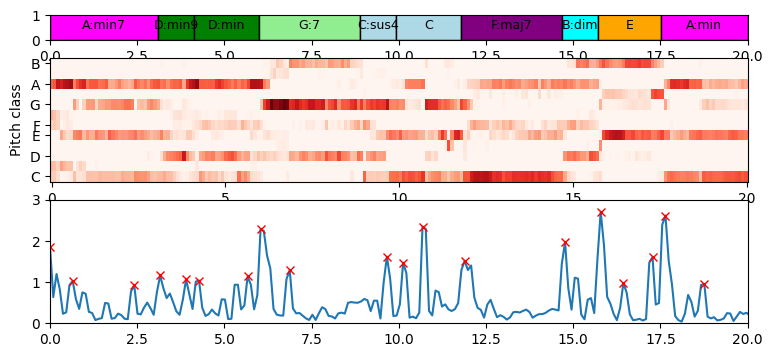

In [54]:
from scipy.signal import find_peaks,medfilt
import itertools
import numpy as np

harmonic_change = pitchspace.computeHCDF(chroma,5,True)
# adaptive threshold 
# alpha = 0.8
# sig = alpha * harmonic_change - (1-alpha) * medfilt(harmonic_change,15)
peaks,properties = find_peaks(harmonic_change,prominence=0.6,distance=4)
peaks = np.pad(peaks,(1,1),mode="constant",constant_values=(0,chroma.shape[1]-1))

for i0,i1 in itertools.pairwise(peaks):
    pass

fig,(ax0,ax1,ax2)= plt.subplots(3,1,height_ratios=(1,5,5),figsize=(9,4))
utils.plotChordAnnotations(ax0,gt[0],gt[1],(0,20))
utils.plotChromagram(ax1,t_chroma,chroma,(0,20))
ax2.plot(t_chroma,harmonic_change)
ax2.plot(t_chroma[peaks],harmonic_change[peaks],"xr")
ax2.set_ylim(0,3)
ax2.set_xlim(0,20)


### Transsprition Results

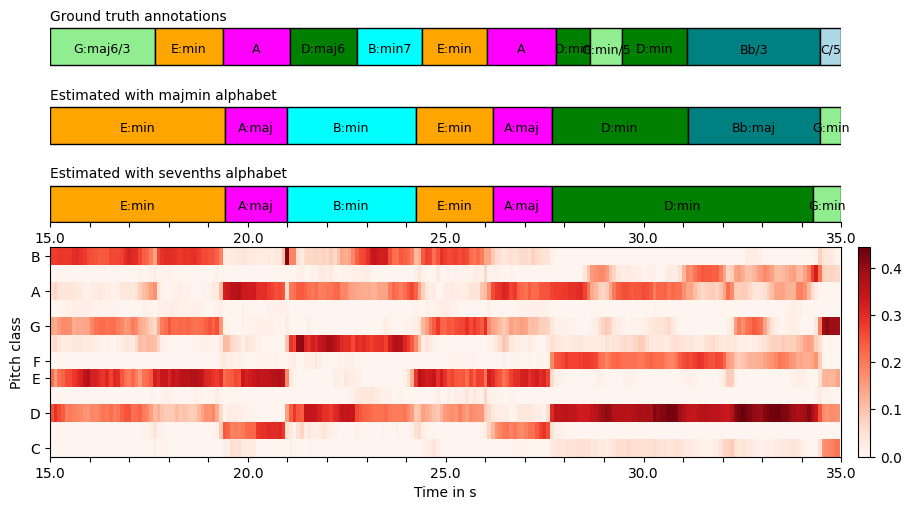

In [1]:
from visualization import visualizationApp
%matplotlib inline
visualizationApp("/home/max/ET-TI/Masterarbeit/chord-recognition/results");

### Chromagram analysis

In [4]:
from visualization import chromaApp
%matplotlib inline
# set path to chromadata file
filepath = "/home/max/ET-TI/Masterarbeit/chord-recognition/models/chromadata_root_invariant_crp_rp_split_1.hdf5" 
chromaApp(filepath)

IntRangeSlider(value=(25, 75), description='select column Index:', layout=Layout(width='30%'))

Output()

### Comparison of results between rp and median filtering and the deep chroma processor

In [2]:
from visualization import load_results
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

results_median,datasets = load_results("/home/max/ET-TI/Masterarbeit/chord-recognition/results/median_7_hmm_025.hdf5")
results_rp,_ = load_results("/home/max/ET-TI/Masterarbeit/chord-recognition/results/rp_25_25_hmm_025.hdf5")
results_dcp,_ = load_results("/home/max/ET-TI/Masterarbeit/chord-recognition/results/deepchroma")

majmin_dcp = [100*x.majmin_f for x in results_dcp]
sevenths_dcp = [100*x.sevenths_f for x in results_dcp]

# 
comparison_median_dcp = [(x,y) for x,y in zip(results_median,results_dcp) if x.majmin_f > y.majmin_f ]
# for data in comparison_median_dcp:
#     print(f"{data[0].name} -{data[0].track_id} - MEDIAN: {data[0].majmin_f} , DCP: {data[1].majmin_f}")

print(f"Number of tracks where the DCP was scoring lower than the template approach: {len(comparison_median_dcp)} ({len(comparison_median_dcp)/len(majmin_dcp)})")


outliers = [x for x in results_median if x.majmin_f <0.5]
outliers = sorted(outliers,key=lambda x : x.majmin_wscr)#

# print out table for thesis
# print("Title","majmin_f","majmin_f","Remarks")
# for x in outliers:
#     for track in results_dcp:
#         if track.name == x.name:
#                 dcp_f_score = track.majmin_f
#     print(x.name.replace("_"," "),100*dcp_f_score,100*x.majmin_f,"placeholder")



print(f"Number of outliers majmin:,{len(outliers)},{len(outliers)/(len(results_median)/100):0.1f}%")

outliers = [x for x in results_median if x.sevenths_f < 0.5]
outliers = sorted(outliers,key=lambda x : x.majmin_wscr)
print(f"Number of outliers sevenths:,{len(outliers)},{len(outliers)/(len(results_median)/100):0.1f}%")

good_results = [x for x in results_median if x.majmin_f > 0.75 and x.sevenths_f > 0.75]
print(f"Number of songs that score above 75 in both datasets: {len(good_results)},{len(good_results)/(len(results_median)/100):0.1f}%")

majmin_f_median = [100*x.majmin_f for x in results_median]
sevenths_f_median = [100*x.sevenths_f for x in results_median]
majmin_f_rp = [100*x.majmin_f for x in results_rp]
sevenths_f_rp = [100*x.sevenths_f for x in results_rp]


fig, ax1 = plt.subplots(figsize=(3, 5))
ax1.violinplot([majmin_f_median,majmin_f_rp,majmin_dcp],showmeans=True, showmedians=False,
        showextrema=False)
xlabels = ["Median","RP","DCP"]
ax1.set_yticks(np.arange(0,110,10))
ax1.set_ylim(0,100)
ax1.set_ylabel("f-score in %")
ax1.set_xticks(np.arange(1, len(xlabels) + 1), labels=xlabels)
ax1.set_xlim(0.5, len(xlabels) + 0.5);
ax1.grid("on")
fig.tight_layout(pad=0.1)
fig.savefig("/home/max/ET-TI/Masterarbeit/latex/figures/median_rp_majmin_result.png")
print("df =",len(results_median))
print(stats.ttest_rel(majmin_f_rp,majmin_f_median))

fig, ax1 = plt.subplots(figsize=(3, 5))
ax1.violinplot([sevenths_f_median,sevenths_f_rp,sevenths_dcp],showmeans=True, showmedians=False,
        showextrema=False)
xlabels = ["Median","RP","DCP"]
ax1.set_yticks(np.arange(0,110,10))
ax1.set_ylim(0,100)
ax1.set_ylabel("f-score in %")
ax1.set_xticks(np.arange(1, len(xlabels) + 1), labels=xlabels)
ax1.set_xlim(0.5, len(xlabels) + 0.5);
ax1.grid("on")
fig.tight_layout(pad=0.1)
fig.savefig("/home/max/ET-TI/Masterarbeit/latex/figures/median_rp_sevenths_result.png")
print(stats.ttest_rel(sevenths_f_rp,sevenths_f_median))

FileNotFoundError: [Errno 2] Unable to open file (unable to open file: name = '/home/max/ET-TI/Masterarbeit/chord-recognition/results/median_7_hmm_025.hdf5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

### Study on source separation

Majmin
Ttest_relResult(statistic=-2.0577927431862313, pvalue=0.04033568076093228)
Ttest_relResult(statistic=-6.150336937974665, pvalue=2.0728979346929052e-09)
Ttest_relResult(statistic=-6.3654777597922925, pvalue=5.982841462545599e-10)
Ttest_relResult(statistic=1.8354295676872752, pvalue=0.06727375590600206)
Sevenths
Ttest_relResult(statistic=-0.8709018184694489, pvalue=0.3843930144541672)
Ttest_relResult(statistic=-4.4230610270851605, pvalue=1.293753476212697e-05)
Ttest_relResult(statistic=-3.4217397581930022, pvalue=0.0006943444161373779)
Ttest_relResult(statistic=0.0607545708684991, pvalue=0.9515886673108985)


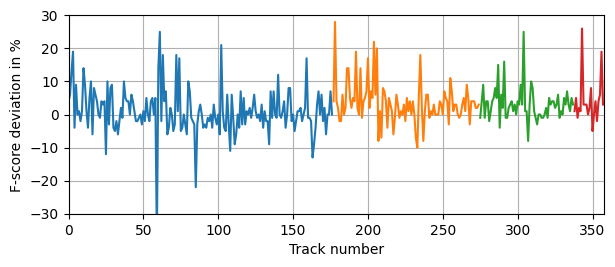

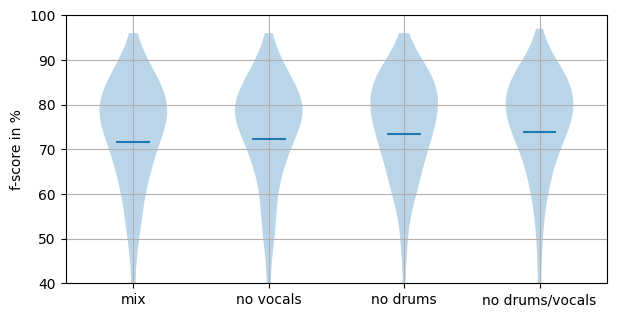

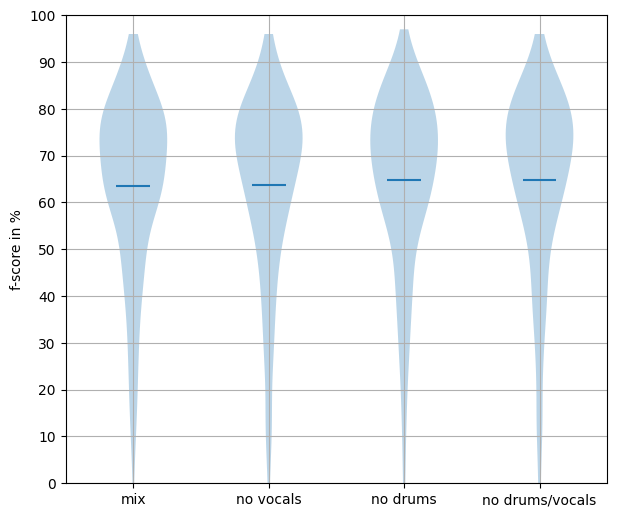

In [66]:
source_separation = ["none","vocals","drums","both"]
DEEP_CHROMA = False

results = {}
for source_sep in source_separation:
        if DEEP_CHROMA:
                results[source_sep], datasets = evaluate.load_results(f"/home/max/ET-TI/Masterarbeit/chord-recognition/results/{source_sep}_deepchroma")
        else:
                results[source_sep], datasets = evaluate.load_results(f"/home/max/ET-TI/Masterarbeit/chord-recognition/results/{source_sep}_median_7_prob_025")
      

# print out possible outliers
# outliers = [x.name for x in results["none"] if x.majmin_f < 0.4]
# print(outliers)

# list of tracks that should be excluded due to issues with the annotations / or lack of harmonic content
outliers = ['03_-_Anna_(Go_To_Him)', # tuning issues
            '10_-_Lovely_Rita', # tuning issues
            'CD1_-_05_-_Wild_Honey_Pie', # little harmonic content
            'CD1_-_06_-_The_Continuing_Story_of_Bungalow_Bill', # TODO: find out why the annotations are wrong.. chroma issues? 
            'CD2_-_12_-_Revolution_9',  # little harmonic content
            '08_-_Within_You_Without_You', # leslie effect on piano => bad chroma
            '02 Another One Bites The Dust', # little harmonic content
            '16 We Will Rock You', # little harmonic content
            "Stalker's Day Off (I've Been Hanging Around)", # faulty audio / issues with annotations
            'Stand Your Ground'  # faulty audio / issues with annotations
]

# outliers = []  

majmin_results_none = [100*x.majmin_f for x in results["none"] if x.name not in outliers]
majmin_results_vocals = [100*x.majmin_f for x in results["vocals"] if x.name not in outliers]
majmin_results_drums = [100*x.majmin_f for x in results["drums"] if x.name not in outliers]
majmin_results_both = [100*x.majmin_f for x in results["both"] if x.name not in outliers]
sevenths_results_none = [100*x.sevenths_f for x in results["none"] if x.name not in outliers]
sevenths_results_vocals = [100*x.sevenths_f for x in results["vocals"] if x.name not in outliers]
sevenths_results_drums = [100*x.sevenths_f for x in results["drums"] if x.name not in outliers]
sevenths_results_both = [100*x.sevenths_f for x in results["both"] if x.name not in outliers]

source_sep = "both"
deviation = [100* (y.majmin_f-x.majmin_f) for x,y in zip(results["none"],results[source_sep])]
fig,ax = plt.subplots(figsize=(6, 2.5))
length = 0
for dset in datasets:
        # compute deviation depending on dataset (To highlight the gain for RWC Pop )
        data = [100* (y.majmin_f-x.majmin_f) for x,y in zip(results["none"],results[source_sep]) if x.dataset ==dset]
        index = np.arange(length,length+len(data),1)
        length += len(data)
        ax.plot(index,data)
ax.set_ylabel("F-score deviation in %")
ax.set_xlabel("Track number")
if source_sep == "vocals":
        plt.legend(["Beatles","RWC Pop","RW","Queen"],bbox_to_anchor=(0, 1.02, 1, 0.2),mode="expand",loc="lower left",ncol=4)
ax.grid()
ax.set_xlim(0,len(results[source_sep]))
ax.set_ylim(-30,30)
fig.tight_layout(pad=0.1)
fig.savefig(f"/home/max/ET-TI/Masterarbeit/latex/figures/deviation_fscore_{source_sep}.png")

fig, ax1 = plt.subplots(figsize=(6, 3))
ax1.violinplot([majmin_results_none,majmin_results_vocals,majmin_results_drums,majmin_results_both],showmeans=True, showmedians=False,
        showextrema=False)
xlabels = ["mix","no vocals","no drums","no drums/vocals"]
ax1.set_yticks(np.arange(0,110,10))
ax1.set_ylim(40,100)
ax1.set_ylabel("f-score in %")
ax1.set_xticks(np.arange(1, len(xlabels) + 1), labels=xlabels)
ax1.set_xlim(0.5, len(xlabels) + 0.5);
ax1.grid("on")
fig.tight_layout(pad=0.1)
if DEEP_CHROMA:
        fig.savefig("/home/max/ET-TI/Masterarbeit/latex/figures/source_separation_majmin_dcp_result.png")
else:
        fig.savefig("/home/max/ET-TI/Masterarbeit/latex/figures/source_separation_majmin_result.png")

print("Majmin")
print(stats.ttest_rel(majmin_results_none,majmin_results_vocals))
print(stats.ttest_rel(majmin_results_none,majmin_results_drums))
print(stats.ttest_rel(majmin_results_none,majmin_results_both))
print(stats.ttest_rel(majmin_results_both,majmin_results_drums))

fig, ax1 = plt.subplots(figsize=(6, 5))
ax1.violinplot([sevenths_results_none,sevenths_results_vocals,sevenths_results_drums,sevenths_results_both],showmeans=True, showmedians=False,
        showextrema=False)
xlabels = ["mix","no vocals","no drums","no drums/vocals"]
ax1.set_yticks(np.arange(0,110,10))

ax1.set_ylim(0,100)
ax1.set_ylabel("f-score in %")
ax1.set_xticks(np.arange(1, len(xlabels) + 1), labels=xlabels)
ax1.set_xlim(0.5, len(xlabels) + 0.5);
ax1.grid("on")
fig.tight_layout(pad=0.1)
if DEEP_CHROMA:
        fig.savefig("/home/max/ET-TI/Masterarbeit/latex/figures/source_separation_sevenths_dcp_result.png")
else:
        fig.savefig("/home/max/ET-TI/Masterarbeit/latex/figures/source_separation_sevenths_result.png")

print("Sevenths")
print(stats.ttest_rel(sevenths_results_none,sevenths_results_vocals))
print(stats.ttest_rel(sevenths_results_none,sevenths_results_drums))
print(stats.ttest_rel(sevenths_results_none,sevenths_results_both))
print(stats.ttest_rel(sevenths_results_both,sevenths_results_drums))


Bigram analysis DEMO


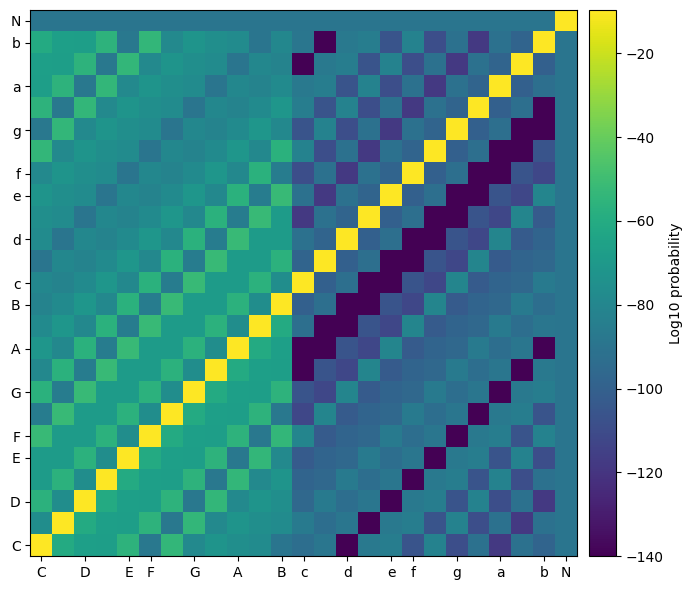

In [10]:
print("Bigram analysis DEMO")
import train
A = train.bigramAnalysis(["beatles"],split=0)
fig,(ax,ax_cbar) = plt.subplots(1,2,width_ratios=(10,0.5),figsize=(7,6))
img = ax.imshow(20*np.log10(A.T+np.finfo(float).eps),origin="lower",vmin=-140)
ticklabels = ["C","D","E","F","G","A","B","c","d","e","f","g","a","b","N"]
ticks = [0,2,4,5,7,9,11,12,14,16,17,19,21,23,24]
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_xticklabels(ticklabels)
ax.set_yticklabels(ticklabels)
plt.colorbar(img,cax=ax_cbar)
ax_cbar.set_ylabel("Log10 probability")
fig.tight_layout()
plt.show()